In [38]:
from bs4 import BeautifulSoup
import re
import requests
import json
import pandas as pd

<h2>Parsing Salaries from Archinect.com</h2>
<p>I use beautiful soup to parse survey data on Archinect.com. The data from the survey is already structured html, so I broke parsing functions into 3 parts. The sub functions deal with parsing each part.</p>

In [39]:
def parse_details1(details_1):
    
    # Initialize with NA or default values
    firm_type = "NA"
    firm_size = "NA"
    health_insurance = "NA"
    overtime = "NA"
    vacation_days = "NA"
    annual_bonus = "NA"

    # Identify details in subcol-1
    for detail in details_1:
        if detail == "": #ignore empty strings
            continue
        elif "People" in detail:
            firm_size = detail
        elif "Health Insurance" in detail:
            health_insurance = "Yes"
        elif "Overtime" in detail:
            overtime = detail
        elif "Days Vacation" in detail:
            vacation_days = detail.replace(" Days Vacation", "")
        elif "Bonus" in detail:
            annual_bonus = detail.replace("$", "").replace(" Bonus", "")
        else:
            firm_type = detail
    return firm_type, firm_size, health_insurance, overtime, vacation_days, annual_bonus

In [40]:
# Test cases for parse_details1 function
#return format is: firm_type, firm_size, health_insurance, overtime, vacation_days, annual_bonus
test_cases = [
  (['Individual', '16-30 People', 'Health Insurance', '15 Days Vacation', '$1,000 Bonus'], ("Individual", "16-30 People", "Yes", "NA", "15", "1,000")),
  (['Boutique', '6-10 People'], ("Boutique", "6-10 People", "NA", "NA", "NA", "NA")),
  (['101-200 People'], ("NA", "101-200 People", "NA", "NA", "NA", "NA")),
   (['No Overtime'], ("NA", "NA", "NA", "No Overtime", "NA", "NA")),
   (['Corporate', '31-50 People', 'Health Insurance', 'Unpaid Overtime', '15 Days Vacation', '$10,000 Bonus'], ("Corporate", "31-50 People", "Yes", "Unpaid Overtime", "15", "10,000")),
]

# Run test cases
for i, (input_data, expected_output) in enumerate(test_cases):
  result = parse_details1(input_data)
  assert result == expected_output, f"Test case {i+1} failed: expected {expected_output}, got {result}"
print("All test cases passed!")


All test cases passed!


In [41]:
def parse_details2(details_2):
  # Initialize with NA or default values
  work_status = "NA"
  years_of_experience = "NA"
  age = "NA"
  gender = "NA"
  licensed = "No"

  # Identify details in subcol-2
  for detail in details_2:
      if detail == "": #ignore empty strings
        continue
      elif "time" in detail:
          work_status = detail
      elif "Freelance" in detail:
          work_status = detail
      elif "Years of Experience" in detail:
          #if detail is < 1 Years of Experience then
            if "<" in detail:
                years_of_experience = "< 1"
            else:
                years_of_experience = detail.split()[0]  # Assuming the first part is the number
      elif "Years old" in detail:
          age = detail.split()[0]  # Assuming the first part is the number 
      elif "Licensed" in detail:
          licensed = "Licensed"
      else:
          gender = detail

  return work_status, years_of_experience, age, gender, licensed


In [42]:
# Test cases for parse_details2 function
test_cases_parse_details2 = [
  (['Full-time', '3-5 Years of Experience', '26-30 Years old', 'Male', 'Licensed'], ("Full-time", "3-5", "26-30", "Male", "Licensed")),
  (['Full-time', '2 Years of Experience', '21-25 Years old', 'Female'], ("Full-time", "2", "21-25", "Female", "No")),
  (['', '3-5 Years of Experience', '21-25 Years old', 'Male'], ("NA", "3-5", "21-25", "Male", "No")),
  (['Part-time', '8-10 Years of Experience', '26-30 Years old', 'Female'], ("Part-time", "8-10", "26-30", "Female", "No")),
  (['Freelance', '11-15 Years of Experience', '46-50 Years old', 'Male', 'Licensed'], ("Freelance", "11-15", "46-50", "Male", "Licensed")),
  (['Full-time', '6-7 Years of Experience', '26-30 Years old', 'Male'], ("Full-time", "6-7", "26-30", "Male", "No")),
  (['Full-time', '3-5 Years of Experience', '26-30 Years old', 'Gender: Other'], ("Full-time", "3-5", "26-30", "Gender: Other", "No")),
  (['Full-time', '3-5 Years of Experience', '26-30 Years old', 'Female'], ("Full-time", "3-5", "26-30", "Female", "No")),
  (['Full-time', '< 1 Years of Experience', '21-25 Years old', 'Female'], ("Full-time", "< 1", "21-25", "Female", "No")),
  (['Full-time', '26-30 Years of Experience', '51-55 Years old', 'Male', 'Licensed'], ("Full-time", "26-30", "51-55", "Male", "Licensed"))
]

# Run test cases
for i, (input_data, expected_output) in enumerate(test_cases_parse_details2):
  result = parse_details2(input_data)
  assert result == expected_output, f"Test case {i+1} failed: expected {expected_output}, got {result}"
print("All test cases for parse_details2 passed!")

All test cases for parse_details2 passed!


In [43]:
def parse_entry(entry):
    id=entry[0]
    soup = BeautifulSoup(entry[1], 'html.parser')

    # Extract job satisfaction (from img tag)
    job_satisfaction_img = soup.find('img', class_='emoticon')
    if job_satisfaction_img and job_satisfaction_img.has_attr('data-original-title'):
        job_satisfaction = job_satisfaction_img['data-original-title'].split(': ')[1]
    else:
        job_satisfaction = "NA"

    # Extract salary, location, and job title (from h3 tag)
    h3 = soup.find('h3')
    if h3:
        # Extract salary
        salary_tag = h3.find('span', class_='salary')
        #this is either $x per hour or $ per year, parse as is
        
        salary = re.sub(r'[^0-9,]', '', salary_tag.text) if salary_tag else "NA"
        salary_unit = re.sub(r'[^a-zA-Z]', '', salary_tag.text) if salary_tag else "NA"

        # Extract location
        location_tag = h3.find_next('span', class_='slash').next_sibling if h3.find('span', class_='slash') else ""
        location = location_tag.strip() if location_tag else "NA"

        # Extract job title
        job_title_tag = h3.find_all('span', class_='slash')[-1].next_sibling if h3.find_all('span', class_='slash') else ""
        job_title = job_title_tag.strip() if job_title_tag else "NA"
    else:
        salary = location = job_title = "NA"

    # Extract details from subcol-1
    subcol_1 = soup.find('ul', class_='subcol-1')
    details_1 = [li.get_text(strip=True) for li in subcol_1.find_all('li')] if subcol_1 else []
    firm_type, firm_size, health_insurance, overtime, vacation_days, annual_bonus = parse_details1(details_1)
    
    # Extract details from subcol-2
    subcol_2 = soup.find('ul', class_='subcol-2')
    details_2 = [li.get_text(strip=True) for li in subcol_2.find_all('li')] if subcol_2 else []
    work_status, years_of_experience, age, gender, licensed = parse_details2(details_2)


    # Extract details from subcol-3
    subcol_3 = soup.find('ul', class_='subcol-3')
    details_3 = [li.get_text(strip=True) for li in subcol_3.find_all('li')] if subcol_3 else []
    undergraduate_school = next((x.replace("UG: ", "").strip() for x in details_3 if x.startswith("UG:")), "NA")
    graduate_school = next((x.replace("Grad: ", "").strip() for x in details_3 if x.startswith("Grad:")), "NA")
    post_graduate_school = next((x.replace("PhD: ", "").strip() for x in details_3 if x.startswith("PhD:")), "NA")

    # Extract date stamp
    date_stamp = soup.find('div', class_='date-stamp')
    date = date_stamp.get_text(strip=True) if date_stamp else "NA"

    # Construct the JSON structure
    result = {
        "id": id,
        "Job Satisfaction": job_satisfaction,
        "Salary": salary,
        "Salary Unit": salary_unit,
        "Location": location,
        "Job Title": job_title,
        "Firm Type": firm_type,
        "Firm Size": firm_size,
        "Health Insurance": health_insurance,
        "Overtime": overtime,
        "Vacation Days": vacation_days,
        "Annual Bonus": annual_bonus,
        "Work Status": work_status,
        "Years of Experience": years_of_experience,
        "Age": age,
        "Gender": gender,
        "Licensed": licensed,
        "Undergraduate School": undergraduate_school,
        "Graduate School": graduate_school,
        "Post-Graduate School": post_graduate_school,
        "Date": date
    }

    return result


In [44]:
def query_data():
    url = "https://salaries.archinect.com/salarypoll/results" #this is the url to query
    params = {
        'sEcho': '2',
        'iColumns': '2',
        'sColumns': '',
        'iDisplayStart': '0',
        'iDisplayLength': '15000', #set max entries to parse
        'mDataProp_0': '0',
        'mDataProp_1': '1',
        'sSearch': '',
        'bRegex': 'false',
        'sSearch_0': '',
        'bRegex_0': 'false',
        'bSearchable_0': 'false',
        'sSearch_1': '',
        'bRegex_1': 'false',
        'bSearchable_1': 'true',
        'iSortCol_0': '0',
        'sSortDir_0': 'asc',
        'iSortingCols': '1',
        'bSortable_0': 'true',
        'bSortable_1': 'false',
        'age': '[]',
        'gender': '[]',
        'job_title': '[]',
        'primary_market': '[]',
        'experience': '[]',
        'firm_type': '[]',
        'firm_size': '[]',
        'work_status': '[]',
        'license': '[]',
        'health_insurance': '[]',
        'overtime': '[]',
        'annual_bonus': '[]',
        'sort_by': 'id',
        'salary-range': '0;100000',
        'range_plus': 'true',
        'location': 'United States', #this query is for the US, you can remove this to get all data
        'under_graduate_school': '',
        'graduate_school': '',
        'post_graduate_school': '',
        'location_type': 'country',
        'salary_time': '[]',
        'job_satisfaction': '[]',
        '_': '1728972672843'  # This is likely a timestamp parameter
    }

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'X-Requested-With': 'XMLHttpRequest'
    }

    # Make the request
    response = requests.get(url, params=params, headers=headers)

    parsed_data=[]

    if response.status_code == 200:
        try:
            # Parse the JSON response
            json_data = response.json()
            
            for entry in json_data['aaData']:
                if entry[0] != "":  # Filter out entries with empty first elements
                    parsed_entry = parse_entry(entry)
                    parsed_data.append(parsed_entry)

            # Convert the list of dictionaries into a pandas DataFrame
            df = pd.DataFrame(parsed_data)
            return df
        except json.JSONDecodeError:
            print("Failed to decode JSON")
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

<h4>Uncomment the two lines below to query data and save to csv. </h4>
<p>This can take a bit depending on your internet speed and device specs, so if you just want to analyze data please just read data from the pre-run csv.

In [45]:
#uncomment to requery data, otherwise just use read_csv from 
# df = query_data()
# df.to_csv("241114_archinect_salaries_raw.csv", index=False)

In [46]:
#read data
df = pd.read_csv("241114_archinect_salaries_raw.csv")

In [47]:
df['Date']

0        Nov '24
1        Nov '24
2        Nov '24
3        Nov '24
4        Nov '24
          ...   
14669    Apr '13
14670    Apr '13
14671    Apr '13
14672    Apr '13
14673    Apr '13
Name: Date, Length: 14674, dtype: object

<h3>Data cleaning</h3>
<p>Setting correct units, deleting outliers, focusing on US and full-time workers</p>

In [48]:
#remove the prefixes in Undergraduate Schools and Graduate Schools
df['Undergraduate School'] = df['Undergraduate School'].str.replace('UG:', '')
df['Graduate School'] = df['Graduate School'].str.replace('Grad:', '')
df['Post-Graduate School'] = df['Post-Graduate School'].str.replace('PhD:', '')

#remove per from salary type (perhour becomes hour, peryear becomes year)
df['Salary Unit'] = df['Salary Unit'].str.replace('per', '')

#remove Gender from gender (Gender: Other becomes Other)
df['Gender'] = df['Gender'].str.replace('Gender: ', '')

#Licensed values changed to either Yes or No
df["Licensed"] = df["Licensed"].str.replace('Licensed', 'Yes')

#replace 40 in "Years of Experience" with 40+
df['Years of Experience'] = df['Years of Experience'].replace({
            '31- >40': '30-40',   # Replace exact match of '31- >40' to '30-40'
            '40': '> 40'           # Replace exact match of '40' to '>40'
        })

#drop the individuals over 103 age because they seem to be spam inputs
df = df[df['Age']!="103"]

#this entry represents a 18-20 year old earning 200,000+ per HOUR, definitely wrong
df = df[df['id']!=12734]

#this represents a 18-20 year old earning 355 per HOUR as the CEO of a 500+ people firm, definitely wrong
df = df[df['id']!=2653]

In [49]:
#we have a total of 14633 entries (this is not fixed, expect higher number as more entries are added)
df.shape

(14670, 21)

In [50]:
#examine the duplicates, this is probably due to people clicking submit multiple times
duplicates = df[df.duplicated(subset=df.columns.difference(['id']), keep=False)]

#remove the duplicates
df.drop_duplicates(subset=df.columns.difference(['id']), keep='first', inplace=True)

In [51]:
# noticed some weird inputs, investigating
criteria = df["Post-Graduate School"].notna() & (df['Date'] == "Jun '24") & (df['Location'] == "Austin, TX, US")

#this seems like bad data, delete all that meet this criteria
#df[criteria] (uncomment to see)

# Drop the rows that match the criteria
df.drop(df[criteria].index, inplace=True)

In [52]:
#remove ' character from Date, and extract year
df['Date'] = df['Date'].str.replace("'", "")

df['Date']  = pd.to_datetime(df['Date'], format='%b %y')
df['Year'] = df['Date'].dt.year

In [53]:
#currently all values are in strings, I want to convert the numerical values to integers, and have NA be pandas NaN

assert ((df['Salary']=="NA").sum() ==0) #salary doesn't have any NA values, 
df['Salary'] = df['Salary'].str.replace(',', '').astype(int)


In [54]:
assert ((df['Job Satisfaction']=="NA").sum() ==0)
#try to convert Job Satisfaction to int, if fails then put NaN
df['Job Satisfaction'] = pd.to_numeric(df['Job Satisfaction'], errors='coerce')

#set Job Satisfaction to be a categorical feature
df['Job Satisfaction'] = df['Job Satisfaction'].astype(int)

df = df[df['Job Satisfaction'].notna()]

In [55]:
#when I did this 56 duplicates were removed
df.shape

(14577, 22)

In [56]:
#save a copy just in case
df_old=df.copy()

In [57]:
#check type of all columns
print("full time: ", df[df['Work Status']=='Full-time'].shape[0])
print("part time: ", df[df['Work Status']=="Part-time"].shape[0])
print("freelance: ", df[df['Work Status']=="Freelance"].shape[0])
print("not specified: ", df[df['Work Status'].isna()].shape[0])

full time:  12355
part time:  298
freelance:  215
not specified:  1709


<p>To preserve as much data as possible, I convert individuals working fulltime and freelance with hourly income to yearly income by multiplying it by 40*52 hours a year. If you want to be more precise feel free to drop those in entirety. I drop part-time individuals.</p>

In [58]:
#convert the hourly income to annual income if working full time
df_fulltime = df[df['Work Status']!="Part-time"].copy()

#TODO: should the hourly rate be extrapolated or just dropped?
#df_fulltime[(df_fulltime["Salary Unit"] == "hour") & (df_fulltime["Salary"]>100000)]
df_fulltime["Salary"] = df_fulltime.apply(lambda x: x['Salary']*40*52 if x['Salary Unit']=="hour" and x['Work Status']=="Full-time" else x['Salary'], axis=1)


#get rid of entries with annual income less than $10,000 (this is probably people who work much less than 40*52 hours a year)
df_fulltime = df_fulltime[df_fulltime["Salary"]>=10000]

<p>I used the Nominatim package to find latitude and longitude for all locations in the surveys. No need to rerun, my results are saved in location_coordinates.csv</p>

In [59]:
# from geopy.geocoders import Nominatim

# # Initialize the geolocator
# geolocator = Nominatim(user_agent="geoapiExercises")

# # Function to get coordinates
# def get_coordinates(location):
#   try:
#     loc = geolocator.geocode(location)
#     if loc:
#       print(f"Location: {location}, Latitude: {loc.latitude}, Longitude: {loc.longitude}")
#       return (loc.latitude, loc.longitude)
#     else:
#       print(f"Location: {location}, Latitude: None, Longitude: None")
#       return (None, None)
#   except:
#     return (None, None)

# # Get unique locations
# unique_locations = df_fulltime['Location'].unique()

# # Create a dictionary to store the coordinates for each unique location
# location_coordinates = {location: get_coordinates(location) for location in unique_locations}

# # Create new columns for latitude and longitude in the original DataFrame
# df_fulltime['Latitude'] = df_fulltime['Location'].map(lambda x: location_coordinates[x][0])
# df_fulltime['Longitude'] = df_fulltime['Location'].map(lambda x: location_coordinates[x][1])

# import csv

# # Define the CSV file name
# csv_file = "location_coordinates.csv"

# # Write the dictionary to a CSV file
# with open(csv_file, mode='w', newline='') as file:
#   writer = csv.writer(file)
#   writer.writerow(["Location", "Latitude", "Longitude"])  # Write the header
#   for location, coordinates in location_coordinates.items():
#     writer.writerow([location, coordinates[0], coordinates[1]])  # Write the data


In [60]:
# Read the location coordinates from the CSV file
location_df = pd.read_csv("location_coordinates.csv")

# Merge the location coordinates with the main DataFrame
df_fulltime = df_fulltime.merge(location_df, on="Location", how="left")

#drop the columns that are not needed
#df_fulltime.drop(columns=["id", "Salary Unit"], inplace=True)

#replace " People" with "" in Firm Size
df_fulltime['Firm Size'] = df_fulltime['Firm Size'].str.replace(" People", "")
df_fulltime['Firm Size'] = df_fulltime['Firm Size'].str.replace("501 +", "501+")

In [61]:
df_fulltime.columns

Index(['id', 'Job Satisfaction', 'Salary', 'Salary Unit', 'Location',
       'Job Title', 'Firm Type', 'Firm Size', 'Health Insurance', 'Overtime',
       'Vacation Days', 'Annual Bonus', 'Work Status', 'Years of Experience',
       'Age', 'Gender', 'Licensed', 'Undergraduate School', 'Graduate School',
       'Post-Graduate School', 'Date', 'Year', 'Latitude', 'Longitude'],
      dtype='object')

<h4>Initial analysis and cleaning</h4>
<p>After limiting data to just fulltime workers, I take a closer look at the entries and get rid of more "bad" data.</p>

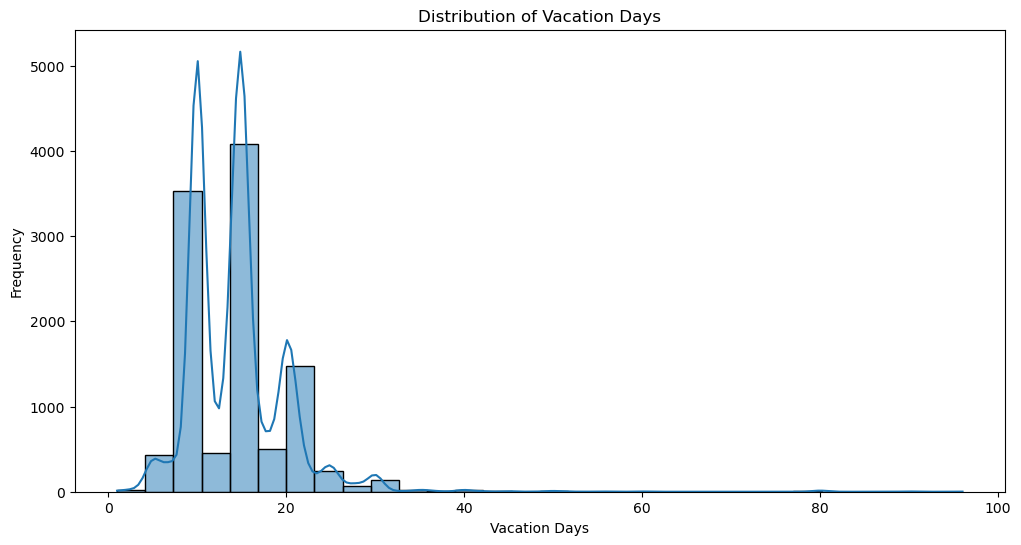

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# df_fulltime[df_fulltime["Vacation Days"]>100]
plt.figure(figsize=(12, 6))
sns.histplot(df_fulltime[df_fulltime["Vacation Days"]<100]["Vacation Days"].dropna(), bins=30, kde=True)
plt.title("Distribution of Vacation Days")
plt.xlabel("Vacation Days")
plt.ylabel("Frequency")
plt.show()

In [63]:
# To get the rows where "Annual Bonus" has things other than numbers and commas
notnarows = df_fulltime[df_fulltime["Annual Bonus"].notna()]
invalid_bonus_rows = notnarows[notnarows["Annual Bonus"].str.contains(r'[^0-9,]', regex=True)]
invalid_bonus_rows


,id,Job Satisfaction,Salary,Salary Unit,Location,Job Title,Firm Type,Firm Size,Health Insurance,Overtime,...,Age,Gender,Licensed,Undergraduate School,Graduate School,Post-Graduate School,Date,Year,Latitude,Longitude
2162,17102,7,105000,CADyear,"Vancouver Junction, WA, US",Intermediate Architect,Corporate,201-500,Yes,Unpaid Overtime,...,41-45,Female,Yes,The University of British Columbia,The University of British Columbia,NaN,2022-06-01,2022,45.627862,-122.687842
7657,8747,6,168000,year,"Shanghai, WV, US",Senior Architect,NaN,11-15,NaN,Unpaid Overtime,...,31-35,Male,No,NaN,NaN,NaN,2016-01-01,2016,39.441487,-78.132225
9888,5573,10,48000,year,"Stuttgart, AR, US",Engineer,Corporate,31-50,Yes,Unpaid Overtime,...,26-30,Male,Yes,NaN,NaN,NaN,2014-06-01,2014,34.500375,-91.552628
10575,4576,10,400000,year,"Boston, MA, US",CEO,NaN,201-500,Yes,Unpaid Overtime,...,41-45,Male,Yes,NaN,NaN,NaN,2014-02-01,2014,42.355433,-71.060511
11131,3825,7,33600,year,"New York, NY, US",Project Manager,Other,6-10,Yes,Unpaid Overtime,...,31-35,Female,No,NaN,NaN,NaN,2013-11-01,2013,40.712728,-74.006015


In [64]:
#shanghai and stuggart are obviously wrong, so remove ids 5573 and 4576 from df_fulltime
df_fulltime = df_fulltime[df_fulltime['id']!=5573]
df_fulltime = df_fulltime[df_fulltime['id']!=8747]

#do a conversion for the canadian using 1 CAD = 0.72 USD, rewrite id 17103's salary as salary*0.72
df_fulltime.loc[df_fulltime['id']==17102, 'Salary'] = round(105000*0.72)
df_fulltime.loc[df_fulltime['id']==17102, 'Salary Unit'] = "year"
df_fulltime.loc[df_fulltime['id']==17102, 'Annual Bonus'] = str(round(8000*0.72))

#conversion from 1 EUR to 1.08 USD
df_fulltime.loc[df_fulltime['id']==4576, 'Annual Bonus'] = str(round(25000*1.08))
df_fulltime.loc[df_fulltime['id']==3825, 'Annual Bonus'] = str(round(2000*1.08))

In [65]:
#convert annual bonus to numbers
df_fulltime["Annual Bonus"] = df_fulltime["Annual Bonus"].str.replace(r'[^0-9]', '', regex=True).astype(float)

In [66]:
#The annual bonus also revealed some funky salary units, so I will correct these
df_fulltime["Salary Unit"].unique()

array(['year', 'hour', 'CADyear', 'localcurrencyyear', 'CHFyear'],
      dtype=object)

In [67]:
#correct the CAD
df_fulltime.loc[df_fulltime['Salary Unit']=="CADyear",'Salary Unit'] = "year"
df_fulltime.loc[df_fulltime['Salary Unit']=="CADyear",'Salary'] = round(df_fulltime.loc[df_fulltime['Salary Unit']=="CADyear",'Salary']*0.72)

In [68]:
#local currency seems to be just usd, so change it to year
df_fulltime.loc[df_fulltime['Salary Unit']=="localcurrencyyear",'Salary Unit'] = "year"

In [69]:
#the salary unit of CHF is in Switzerland, so this is a bad entry, I delete it
print(df_fulltime.loc[df_fulltime['Salary Unit']=="CHFyear"])
df_fulltime = df_fulltime[df_fulltime['id']!=3616]

         id  Job Satisfaction  Salary Salary Unit           Location  \
11228  3616                 7   24000     CHFyear  Neuchatel, KS, US   

      Job Title   Firm Type Firm Size Health Insurance       Overtime  ...  \
11228    Intern  Individual       2-5              NaN  Paid Overtime  ...   

         Age  Gender Licensed Undergraduate School Graduate School  \
11228  26-30  Female      Yes      CEPT University      ETH Zürich   

      Post-Graduate School       Date  Year   Latitude  Longitude  
11228                  NaN 2013-10-01  2013  39.568052 -96.201946  

[1 rows x 24 columns]


In [70]:
#Now the units should only be year and hour (hour kept to refer to those that were converted to annual)
df_fulltime["Salary Unit"].unique()

array(['year', 'hour'], dtype=object)

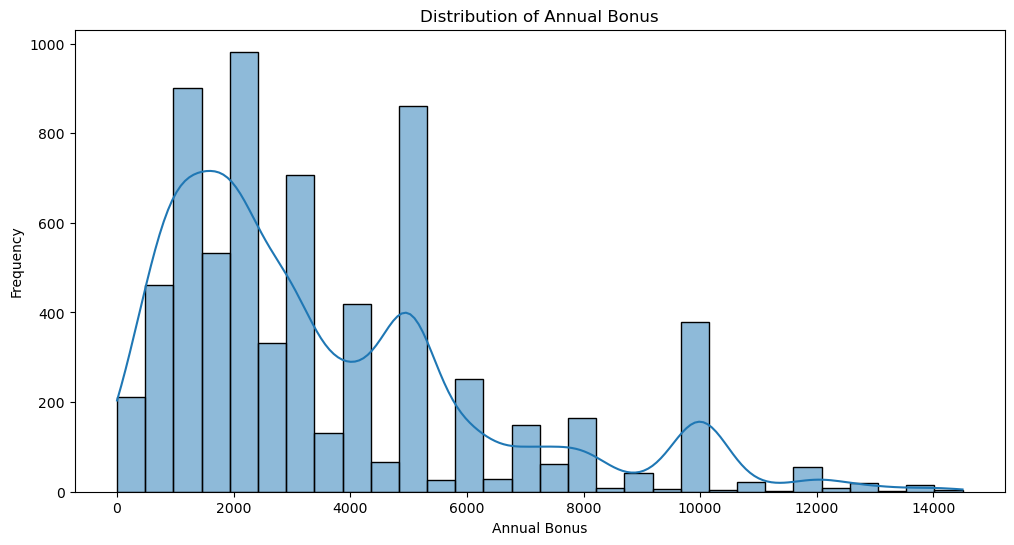

In [71]:

plt.figure(figsize=(12, 6))
sns.histplot(df_fulltime[df_fulltime["Annual Bonus"]<15000]["Annual Bonus"].dropna(), bins=30, kde=True)
plt.title("Distribution of Annual Bonus")
plt.xlabel("Annual Bonus")
plt.ylabel("Frequency")
plt.show()

<h4>Export to csv, this is used for d3.js</h4>

In [72]:
#strip the US because otherwise very repetitive (all locations are in the us)
df_fulltime['Location']=df_fulltime['Location'].str.replace(", US", "")

df_fulltime.to_csv("241114_archinect_salaries_fulltime.csv", index=False)

<h4>More visualization (I did this to understand the data, not directly used in web viz)</h4>

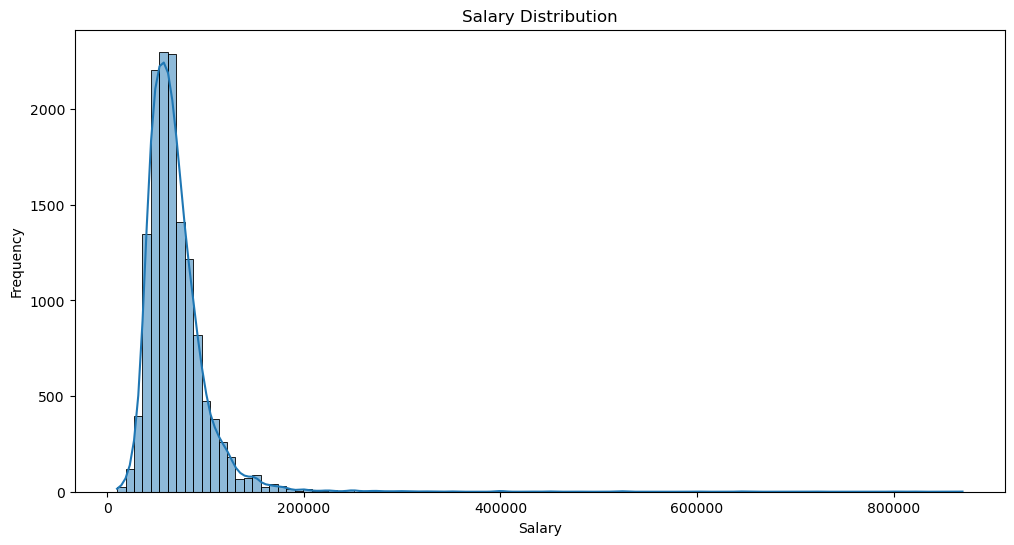

In [73]:
#plot income distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df_fulltime["Salary"], bins=100, kde=True)
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.show()

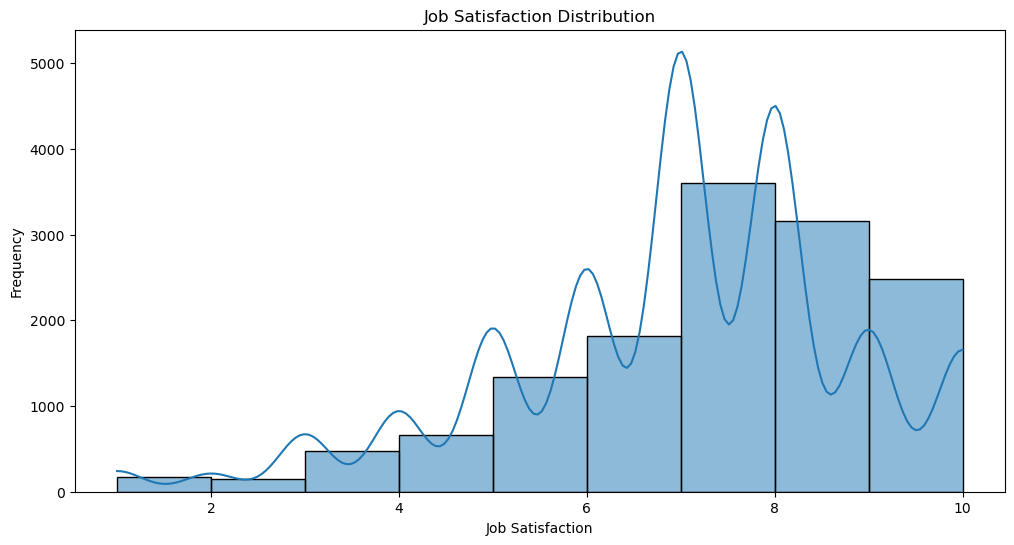

In [74]:
#plot income distribution
import matplotlib.pyplot as plt
import seaborn as sns

#plot job satisfaction distribution (there is only values 0-10)
plt.figure(figsize=(12, 6))
sns.histplot(df_fulltime['Job Satisfaction'], bins=9, kde=True)
plt.title("Job Satisfaction Distribution")
plt.xlabel("Job Satisfaction")
plt.ylabel("Frequency")
plt.show()

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact, interactive_output, Dropdown, widgets

#ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_salary_by_column_by_year(column_name, filter_value):
    df=df_fulltime
    # Filter the DataFrame by the selected job title
    if filter_value == 'All':
        filtered_df = df
    else:    
        filtered_df = df[df[column_name] == filter_value]

    # Calculate the median salary for each year
    median_salary = filtered_df.groupby('Year')['Salary'].median().reset_index()

    # Plotting
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Year', y='Salary', data=filtered_df, showfliers=False) #hue="Year", palette='Set3'
    
    # Move legend to the side
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Year')

    plt.plot(median_salary.index, median_salary['Salary'], color='red', marker='o', label='Median Salary')
    
    plt.title(f'Salary Distribution for {filter_value} by Year')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Function to create the interactive plot with dynamic filter values
def create_interactive_plot():
    # Dropdown for selecting the column
    column_name_dropdown = Dropdown(options=["Job Title", "Firm Type"], description="Column")
    
    # Create an empty filter dropdown that will be updated
    filter_value_dropdown = Dropdown(description='Filter')
    
    # Function to update filter_value options based on selected column_name
    def update_filter_value_options(*args):
        selected_column = column_name_dropdown.value
        unique_values = ['All'] + list(df[selected_column].unique())
        filter_value_dropdown.options = unique_values

    # Attach the update function to the column_name dropdown changes
    column_name_dropdown.observe(update_filter_value_options, 'value')
    
    # Initialize filter dropdown with the default column selected
    update_filter_value_options()

    # Display the widgets and the plot
    ui = widgets.VBox([column_name_dropdown, filter_value_dropdown])
    out = interactive_output(plot_salary_by_column_by_year, {
        'column_name': column_name_dropdown, 
        'filter_value': filter_value_dropdown
    })
    
    display(ui, out)

# Call the function to display the interactive plot
create_interactive_plot()

Output()

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, Dropdown

def plot_median_salary(column_name, n=15):
    # Get the top N values by counts of people with that value
    top_n_vals = df[column_name].value_counts().nlargest(n)
    vals = top_n_vals.index

    # Create a list to hold (value, median_salary) tuples for the legend
    median_salaries = []
    
    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Loop through each value and plot the median salary trend
    for val in vals:
        # Filter the DataFrame by the current value
        filtered_df = df[df[column_name] == val]

        # Calculate the median salary by year
        salary_stats = filtered_df.groupby('Year')['Salary'].median().reset_index()

        # Plot the median salary trend
        line, = plt.plot(salary_stats['Year'], salary_stats['Salary'], marker='o', label=val)

        # Store the overall median salary for the current value
        overall_median = filtered_df['Salary'].median()
        median_salaries.append((val, overall_median, line))

    # Sort median salaries for the legend, but keep track of the original lines
    sorted_median_salaries = sorted(median_salaries, key=lambda x: x[1], reverse=True)

    # Create a custom legend based on the sorted median salaries
    custom_legend = [f"{val}: {median:.0f}" for val, median, _ in sorted_median_salaries]
    handles = [line for _, _, line in sorted_median_salaries]  # Extract lines for legend

    # Plot settings
    plt.title(f'Median Salary Trends by {column_name}')
    plt.xlabel('Year')
    plt.ylabel('Median Salary')
    plt.xticks(salary_stats['Year'])
    plt.legend(handles, custom_legend, title=column_name, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    #print(top_n_vals)

# Call the function with interact
interact(plot_median_salary, 
         n=15,
         column_name=Dropdown(options=["Job Title", "Firm Type", "Firm Size", "Licensed", "Years of Experience", "Age", "Gender", "Job Satisfaction"], description='Column Name'))


interactive(children=(Dropdown(description='Column Name', options=('Job Title', 'Firm Type', 'Firm Size', 'Lic…

<function __main__.plot_median_salary(column_name, n=15)>

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

def sort(vals, column_name, sorting_column_name):
    # Sort the job titles by mean satisfaction
    if column_name == "Years of Experience":
        experience_order = ["< 1", "1", "2", "3", "3-5", "6-7", "8-10", "11-15", "16-20", "21-25", "26-30", "31-40", "> 40"]

        # Convert the 'Years of Experience' column to a categorical type with the specified order
        vals['Years of Experience'] = pd.Categorical(vals['Years of Experience'], categories=experience_order, ordered=True)

        # Sort the DataFrame by the 'Years of Experience' column
        vals = vals.sort_values('Years of Experience')

    elif column_name not in ["Age", "Job Satisfaction"]:
        vals = vals.sort_values(by=sorting_column_name)
    return vals

def process_counts (df, column_name, n=20):
        #if column name is in ["Undergraduate School", "Graduate School", "Post-Graduate School"] then we want to plot the top 20:
    if column_name in ["Undergraduate School", "Graduate School", "Location"]:
        response_counts = df[column_name].value_counts().nlargest(n).reset_index(name='Response Count')
    else:
        # Calculate the median salary across all years for each job title
        response_counts = df.groupby(column_name).size().reset_index(name='Response Count')

    # Sort the job titles by median salary
    response_counts = sort(response_counts, column_name, "Response Count")

    return response_counts

def process_median_salary(df, column_name, n=20):
    if column_name in ["Undergraduate School", "Graduate School", "Location"]:
        # Calculate the top 20 locations by responder count
        top_responses = df[column_name].value_counts().nlargest(n).index
        # Filter the DataFrame to include only the top locations
        filtered_df = df[df[column_name].isin(top_responses)]

         # Calculate the median salary across all years for each job title
        median_salary_per_job = filtered_df.groupby(column_name)['Salary'].median().reset_index()
    else:
        median_salary_per_job = df.groupby(column_name)['Salary'].median().reset_index()

    # Sort the job titles by median salary
    median_salary_per_job = sort(median_salary_per_job, column_name, "Salary")

    return median_salary_per_job

def process_mean_satisfaction(df, column_name, n=20):
    if column_name in ["Undergraduate School", "Graduate School", "Location"]:
        # Calculate the top 20 locations by responder count
        top_responses = df[column_name].value_counts().nlargest(n).index
        # Filter the DataFrame to include only the top locations
        filtered_df = df[df[column_name].isin(top_responses)]

         # Calculate the median salary across all years for each job title
        mean_satisfaction_per_job = filtered_df.groupby(column_name)['Job Satisfaction'].mean().reset_index()
    else:
        mean_satisfaction_per_job = df.groupby(column_name)['Job Satisfaction'].mean().reset_index()

    mean_satisfaction_per_job = sort(mean_satisfaction_per_job, column_name, "Job Satisfaction")

    return mean_satisfaction_per_job

def plot_response_by_column(df):

    def plotting_func(column_name, feature_type = 'Response Count'):
        if feature_type == 'Response Count':
            response = process_counts(df, column_name)
        elif feature_type == 'Salary':
            response = process_median_salary(df, column_name)
        else:
            response = process_mean_satisfaction(df, column_name)


        # Set up the figure
        plt.figure(figsize=(12, 6))

        # Create a bar plot for the sorted median salaries
        plt.bar(response[column_name], response[feature_type], color='skyblue')

        # Plot settings
        plt.title(f'{feature_type} by {column_name}')
        plt.ylabel(feature_type)
        plt.xlabel(column_name)
        plt.xticks(rotation=45, ha='right',va='top')
        plt.grid(True, axis='x')
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

    return plotting_func

# Call the function to plot
interact(plot_response_by_column(df_fulltime), feature_type=Dropdown(options=["Response Count", "Salary", "Job Satisfaction"]),column_name=Dropdown(options=["Job Satisfaction", "Job Title", "Firm Type", "Firm Size", "Licensed", "Years of Experience", "Age", "Gender", "Location", "Undergraduate School", "Graduate School"], description='Column Name'))

interactive(children=(Dropdown(description='Column Name', options=('Job Satisfaction', 'Job Title', 'Firm Type…

<function __main__.plot_response_by_column.<locals>.plotting_func(column_name, feature_type='Response Count')>

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

def plot_mean_satisfaction_by_column(column_name):
    df = df_fulltime  # Assuming df_fulltime is your DataFrame
    
    # Calculate the mean job satisfaction across the selected column
    mean_satisfaction_per_job = df.groupby(column_name)['Job Satisfaction'].mean().reset_index()

    # Conditional sorting: retain natural order for "Age" and "Years of Experience"
    if column_name == "Years of Experience":
        experience_order = ["< 1", "1", "2", "3", "3-5", "6-7", "8-10", "11-15", "16-20", "21-25", "26-30", "31-40", "> 40"]

        # Convert the 'Years of Experience' column to a categorical type with the specified order
        mean_satisfaction_per_job['Years of Experience'] = pd.Categorical(mean_satisfaction_per_job['Years of Experience'], categories=experience_order, ordered=True)

        # Sort the DataFrame by the 'Years of Experience' column
        mean_satisfaction_per_job = mean_satisfaction_per_job.sort_values('Years of Experience')

    elif column_name !="Age":
        mean_satisfaction_per_job = mean_satisfaction_per_job.sort_values(by='Job Satisfaction')
        

    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Create a horizontal bar plot for the mean job satisfaction
    plt.bar(mean_satisfaction_per_job[column_name], mean_satisfaction_per_job['Job Satisfaction'], color='skyblue')

    # Plot settings
    plt.title(f'Mean Job Satisfaction by {column_name}')
    plt.ylabel('Mean Job Satisfaction')
    plt.xlabel(column_name)
    plt.xticks(rotation=45, ha='right',va='top')
    plt.grid(True, axis='x')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to plot with an interactive dropdown
interact(plot_mean_satisfaction_by_column, 
         column_name=Dropdown(options=["Job Title", "Firm Type", "Firm Size", "Licensed", 
                                       "Years of Experience", "Age", "Gender"], 
                              description='Column Name'))


interactive(children=(Dropdown(description='Column Name', options=('Job Title', 'Firm Type', 'Firm Size', 'Lic…

<function __main__.plot_mean_satisfaction_by_column(column_name)>

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown, Checkbox

def plot_median_salary_by_column(column_name, grouped=False):
    # Check if the user wants a grouped chart
    if grouped:
        # Calculate the median salary by column and gender
        salary_data = df.groupby([column_name, 'Licensed'])['Salary'].median().reset_index()
        
        # Plotting grouped bar chart
        plt.figure(figsize=(12, 6))
        sns.barplot(data=salary_data, y='Salary', x=column_name, hue='Licensed', palette='Set2')
        
        # Plot settings
        plt.title(f'Grouped Median Salary by {column_name}')
        plt.xlabel('Median Salary')
        plt.ylabel(column_name)
        plt.grid(True, axis='x')
        plt.legend(title='Gender')
        
    else:
        # Calculate the median salary across all years for each category
        median_salary_per_job = df.groupby(column_name)['Salary'].median().reset_index()

        # Sort the categories by median salary
        median_salary_per_job = median_salary_per_job.sort_values(by='Salary')

        # Set up the figure
        plt.figure(figsize=(12, 6))

        # Create a horizontal bar plot for the sorted median salaries
        plt.bar(median_salary_per_job[column_name], median_salary_per_job['Salary'], color='skyblue')

        # Plot settings
        plt.title(f'Median Salary by {column_name}')
        plt.ylabel('Median Salary')
        plt.xlabel(column_name)
        plt.grid(True, axis='x')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to plot with an additional dropdown for grouping
interact(plot_median_salary_by_column, 
         column_name=Dropdown(options=["Job Title", "Firm Type", "Firm Size", "Licensed", "Years of Experience", "Age", "Job Satisfaction"], description='Column Name'),
         grouped=Checkbox(value=False, description='Show Grouped Bar Chart'))


interactive(children=(Dropdown(description='Column Name', options=('Job Title', 'Firm Type', 'Firm Size', 'Lic…

<function __main__.plot_median_salary_by_column(column_name, grouped=False)>

In [80]:
import pandas as pd

def create_matrices(df):
    # First, ensure 'Years of Experience' and 'Firm Type' are categorical
    experience_order = ["< 1", "1", "2", "3", "3-5", "6-7", "8-10", "11-15", "16-20", "21-25", "26-30", "31-40", "> 40"]

    df['Years of Experience'] = pd.Categorical(df['Years of Experience'], categories=experience_order, ordered=True)
    df['Firm Type'] = pd.Categorical(df['Firm Type'])

    # Matrix 1: Job Satisfaction (mean)
    job_satisfaction_matrix = df.pivot_table(index='Firm Type', columns='Years of Experience', 
                                             values='Job Satisfaction', aggfunc='mean')

    # Matrix 2: Salary (median)
    salary_matrix = df.pivot_table(index='Firm Type', columns='Years of Experience', 
                                   values='Salary', aggfunc='median')

    # Matrix 3: Response Count
    response_count_matrix = df.pivot_table(index='Firm Type', columns='Years of Experience', 
                                           values='Job Satisfaction', aggfunc='count')

    return job_satisfaction_matrix, salary_matrix, response_count_matrix

# Sample usage
job_satisfaction_matrix, salary_matrix, response_count_matrix = create_matrices(df_fulltime)

# Display the matrices
print("Job Satisfaction Matrix:")
print(job_satisfaction_matrix)

print("\nSalary Matrix:")
print(salary_matrix)

print("\nResponse Count Matrix:")
print(response_count_matrix)


Job Satisfaction Matrix:
Years of Experience       < 1         1         2         3       3-5  \
Firm Type                                                               
Boutique             7.294118  7.163462  7.122581  7.010381  6.847605   
Corporate            7.194332  7.139683  6.761702  6.917062  6.719486   
Individual           7.043956  6.608247  6.716312  6.813084  6.639344   
Other                7.220930  7.145161  7.070968  7.194915  7.012945   
Starchitect          7.263158  6.571429  6.980000  6.666667  6.609524   

Years of Experience       6-7      8-10     11-15     16-20     21-25  \
Firm Type                                                               
Boutique             7.032720  7.006623  7.111111  7.560000  7.811594   
Corporate            6.693850  6.760211  6.941278  7.033708  7.059603   
Individual           6.345133  6.794393  6.807692  7.148936  7.961538   
Other                6.953975  6.936275  6.868020  7.370787  7.229508   
Starchitect          6.23

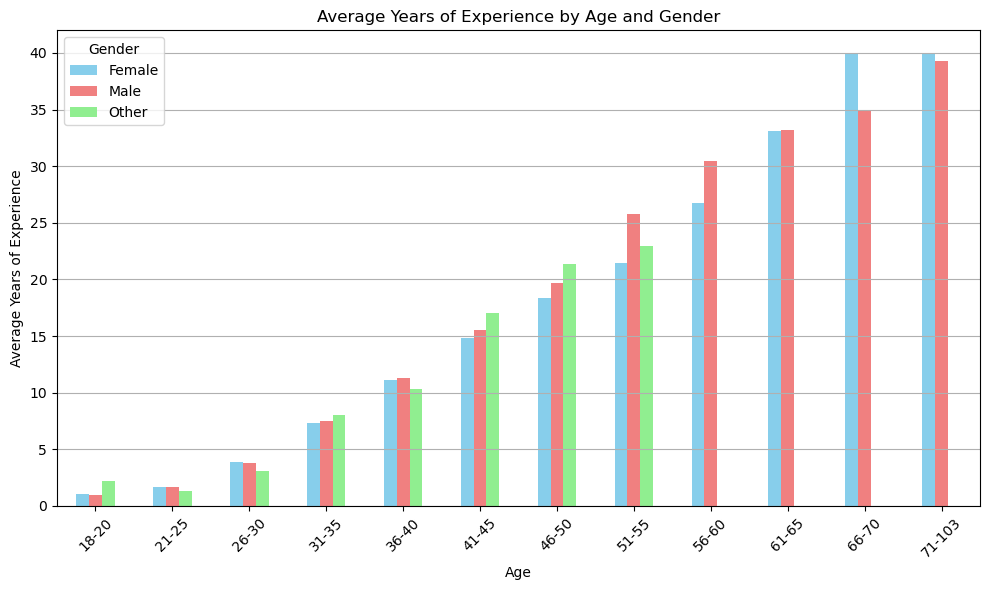

In [81]:
experience_mapping = {

      '< 1':0.5,
      '1':1,
      '2':2,
      '3':3,
      '3-5':4,
      '6-7':6.5,
      '8-10':9,
      '11-15':13,
      '16-20':18,
      '21-25':23,   
      '26-30':28,  
      '31-40':35.5,
      '> 40':40
}

def plot_experience_vs_age_gender(df):
    

    # Map years of experience to median values
    df['Experience_Median'] = df['Years of Experience'].map(experience_mapping)
    #set to float
    df['Experience_Median'] = df["Experience_Median"].astype(float)

    # Group by Age and Gender, then calculate the mean of the median experience values
    mean_experience = df.groupby(['Age', 'Gender'])['Experience_Median'].mean().reset_index()

    # Pivot to make it suitable for a grouped bar plot
    experience_pivot = mean_experience.pivot(index='Age', columns='Gender', values='Experience_Median')

    # Plotting
    experience_pivot.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Average Years of Experience by Age and Gender')
    plt.xlabel('Age')
    plt.ylabel('Average Years of Experience')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_experience_vs_age_gender(df_fulltime)


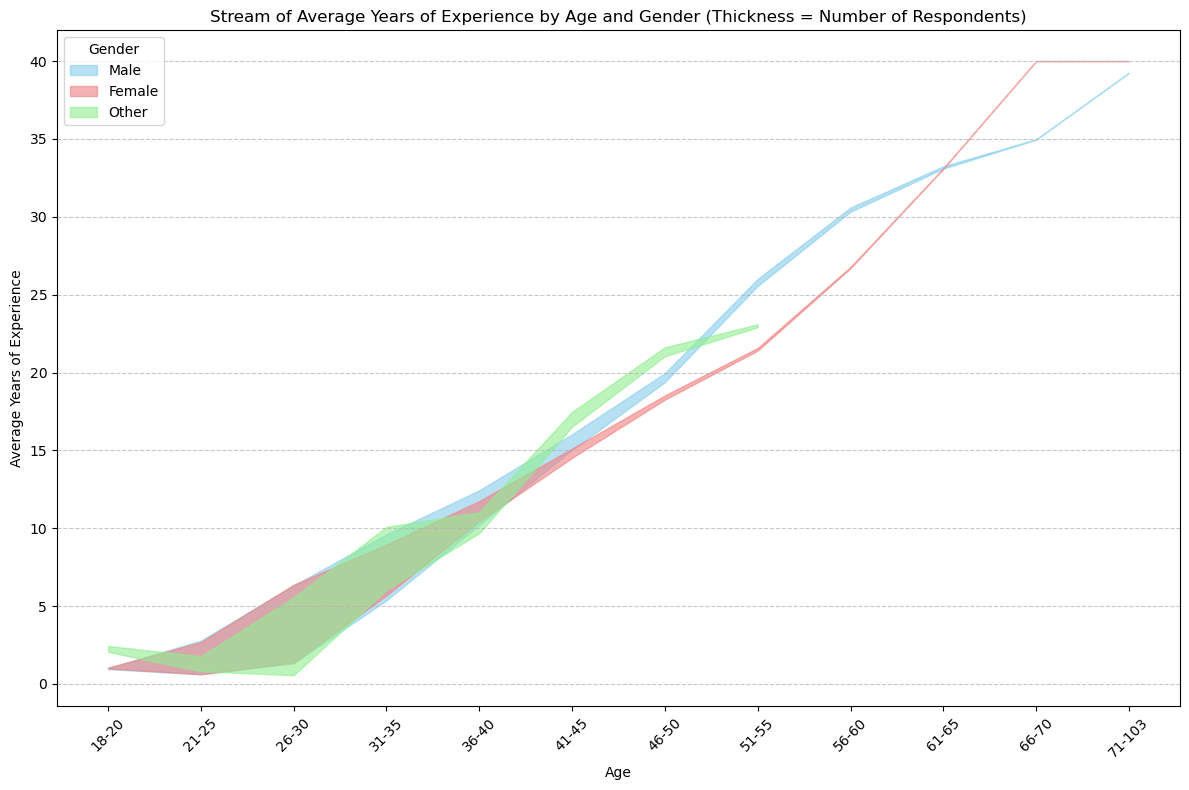

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_experience_vs_age_gender_stream(df):
    # Map years of experience to median values
    df['Experience_Median'] = df['Years of Experience'].map(experience_mapping)
    df['Experience_Median'] = df["Experience_Median"].astype(float)

    # Group by Age and Gender, calculate the mean of the median experience values and count of respondents
    grouped_data = df.groupby(['Age', 'Gender']).agg({
        'Experience_Median': 'mean', 
        'Gender': 'count'  # count of respondents
    }).rename(columns={'Gender': 'Respondent_Count'}).reset_index()

    # Pivot to get experience data in the right format for plotting
    experience_pivot = grouped_data.pivot(index='Age', columns='Gender', values='Experience_Median')
    count_pivot = grouped_data.pivot(index='Age', columns='Gender', values='Respondent_Count')

    # Plot settings
    plt.figure(figsize=(12, 8))

    # Create the stream plot effect by filling between lines, varying thickness with respondent count
    genders = ['Male', 'Female', 'Other']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    for i, gender in enumerate(genders):
        if gender in experience_pivot.columns:
            experience_vals = experience_pivot[gender].values
            respondent_counts = count_pivot[gender].fillna(0).values

            # Normalize the respondent counts to scale the thickness
            respondent_counts = respondent_counts / respondent_counts.max() * 5  # scale factor for thickness

            # Create a "stream" effect by filling between lines with variable width
            plt.fill_between(experience_pivot.index, experience_vals - respondent_counts / 2, 
                             experience_vals + respondent_counts / 2, alpha=0.6, color=colors[i], label=gender)

    # Plot settings
    plt.title('Stream of Average Years of Experience by Age and Gender (Thickness = Number of Respondents)')
    plt.xlabel('Age')
    plt.ylabel('Average Years of Experience')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Gender', loc='upper left')
    plt.tight_layout()
    plt.show()

#df_filtered = df_fulltime[~df_fulltime['Age'].isin(['61-65','66-70', '71-103'])]
plot_experience_vs_age_gender_stream(df_fulltime)


In [83]:
df_fulltime['Years of Experience'].map(experience_mapping)


0         4.0
1        13.0
2         9.0
3         2.0
4        13.0
         ... 
13832     4.0
13833     2.0
13834     9.0
13835     4.0
13836     1.0
Name: Years of Experience, Length: 13834, dtype: category
Categories (13, float64): [0.5 < 1.0 < 2.0 < 3.0 ... 23.0 < 28.0 < 35.5 < 40.0]

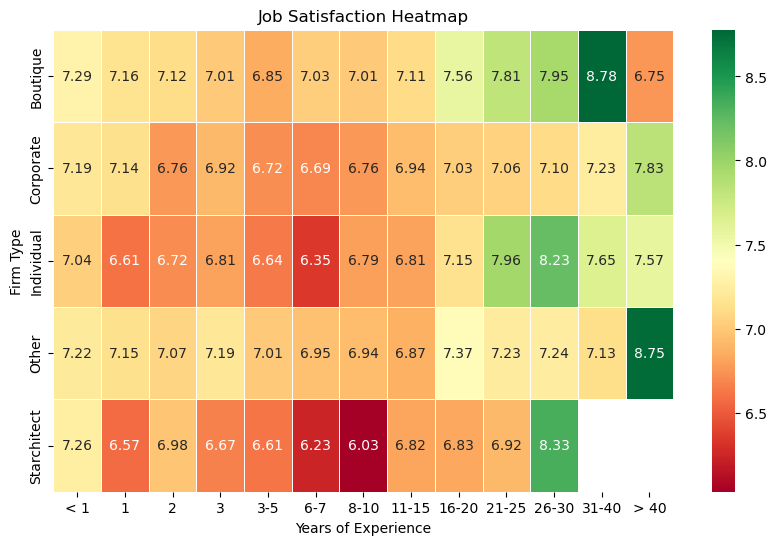

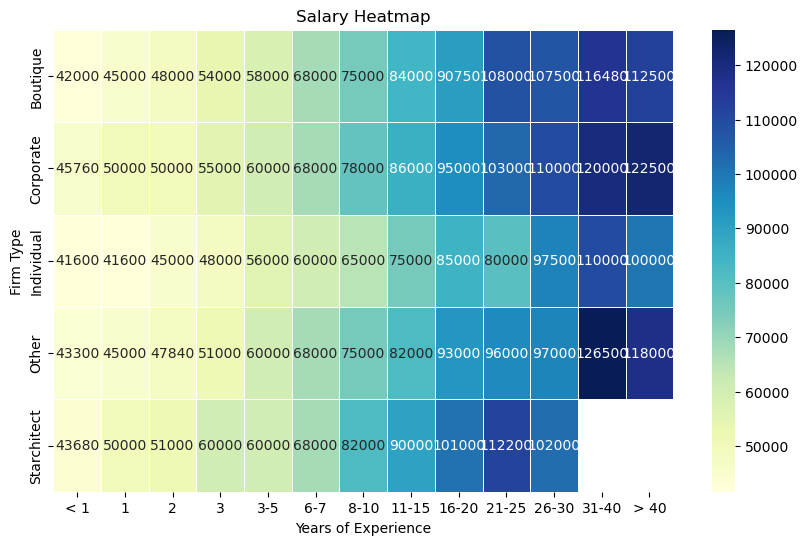

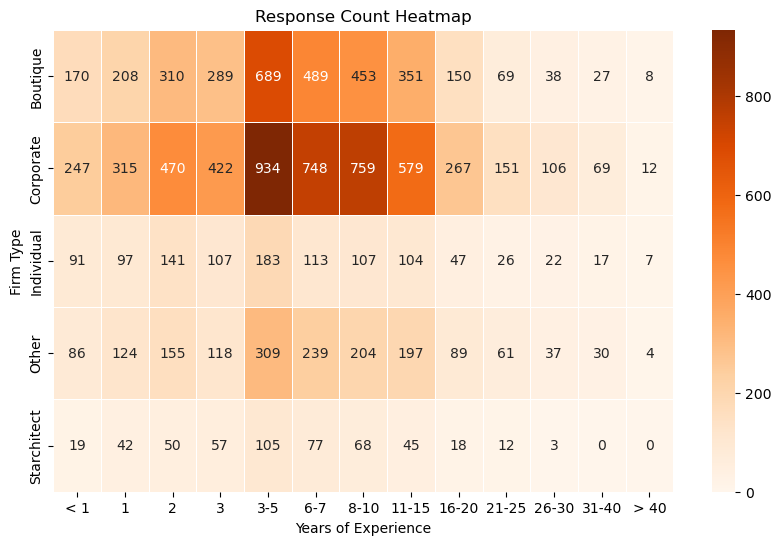

In [84]:
def plot_heatmap(matrix, title, cmap="Blues", fmt='.0f'):
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt=fmt, linewidths=0.5)
    plt.title(title)
    plt.xlabel('Years of Experience')
    plt.ylabel('Firm Type')
    plt.show()

# Sample usage
job_satisfaction_matrix, salary_matrix, response_count_matrix = create_matrices(df_fulltime)

# Visualize the matrices with color
plot_heatmap(job_satisfaction_matrix, 'Job Satisfaction Heatmap', cmap='RdYlGn', fmt='.2f')
plot_heatmap(salary_matrix, 'Salary Heatmap', cmap='YlGnBu')
plot_heatmap(response_count_matrix, 'Response Count Heatmap', cmap='Oranges')